In [1]:
# Step 1 - Load preprocessing outputs and set up environment


%run "./02_preprocessing.ipynb"
# this line runs the complete preprocessing notebook itself

import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import joblib

print("X_train shape:", X_train.shape)
print("X_test  shape:", X_test.shape)
print("y_train distribution:\n", y_train.value_counts(normalize=True))
print("y_test  distribution:\n", y_test.value_counts(normalize=True))
print("\nPreprocessor type:", type(preprocessor))


Initial shape: (15200, 15)
Exact duplicate rows: 192
Duplicate faculty_id: 8


,faculty_id,academic_rank,tenure_status,years_at_institution,base_salary,teaching_load,research_funding,institution_type,department_size,admin_support,work_life_balance,promotion_opportunities,publications_last_3_years,student_evaluation_avg,left_institution
0,10000,Associate Professor,Tenure-Track,17,67410.138471,2,-2604.167089,Technical Institute,23,4,3,6,4,2.971100,0
1,10001,Full Professor,Non-Tenure,6,65578.523052,1,5601.080853,Technical Institute,8,6,6,6,6,3.681743,0
2,10002,Lecturer,Tenured,22,70730.493594,1,65860.624649,Technical Institute,11,9,1,7,9,1.002227,1
3,10003,Associate Professor,Tenured,0,59283.503256,4,41557.812521,Technical Institute,22,5,7,9,4,2.420985,0
4,10004,Associate Professor,Tenure-Track,26,66641.452922,5,26096.583217,Liberal Arts College,49,9,5,5,9,3.261318,0


Train shape: (12006, 13)
Test shape: (3002, 13)

Train target distribution:
left_institution
0    0.760287
1    0.239713
Name: proportion, dtype: float64
Categorical columns: ['academic_rank', 'tenure_status', 'institution_type']
Numeric columns: ['years_at_institution', 'base_salary', 'teaching_load', 'research_funding', 'department_size', 'admin_support', 'work_life_balance', 'promotion_opportunities', 'publications_last_3_years', 'student_evaluation_avg']
Preprocessor fitted successfully!
Processed shape: (12006, 34)
X_train shape: (12006, 13)
X_test  shape: (3002, 13)
y_train distribution:
 left_institution
0    0.760287
1    0.239713
Name: proportion, dtype: float64
y_test  distribution:
 left_institution
0    0.760493
1    0.239507
Name: proportion, dtype: float64

Preprocessor type: <class 'sklearn.compose._column_transformer.ColumnTransformer'>


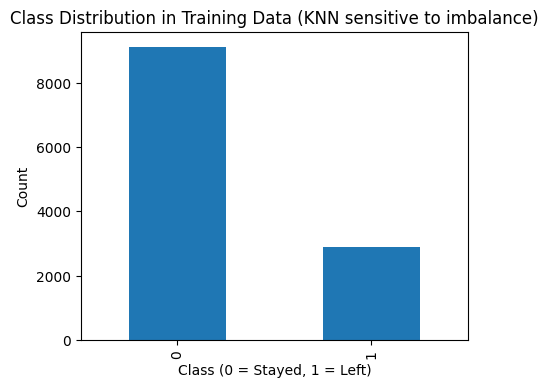

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,4))
y_train.value_counts().plot(kind='bar')
plt.title("Class Distribution in Training Data (KNN sensitive to imbalance)")
plt.xlabel("Class (0 = Stayed, 1 = Left)")
plt.ylabel("Count")
plt.show()


Running PCA for 2D visualization...


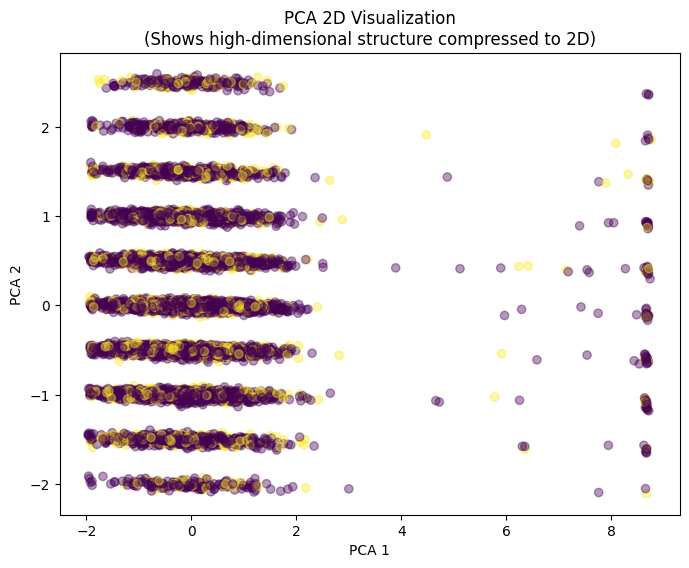

In [3]:
# ============================
# PART 2.3 — PCA Visualization
# ============================

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

print("Running PCA for 2D visualization...")

# ---------------------------------------------------------
# STEP 1 — Transform training data using the preprocessor
# ---------------------------------------------------------
# Preprocessor applies:
# • Scaling
# • OneHotEncoding
# • Missing/outlier flags
# • All your preprocessing pipeline steps
X_train_processed = preprocessor.transform(X_train)

# ---------------------------------------------------------
# STEP 2 — Convert sparse → dense (if needed)
# ---------------------------------------------------------
# OneHotEncoder often outputs sparse matrices.
# PCA may not accept sparse format.
if hasattr(X_train_processed, "toarray"):
    X_train_dense = X_train_processed.toarray()
else:
    X_train_dense = X_train_processed

# ---------------------------------------------------------
# STEP 3 — Apply PCA (reduce ~40D → 2D)
# ---------------------------------------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_dense)

# ---------------------------------------------------------
# STEP 4 — Plot PCA scatter
# ---------------------------------------------------------
plt.figure(figsize=(8,6))
plt.scatter(
    X_pca[:, 0],         # PCA 1 on x-axis
    X_pca[:, 1],         # PCA 2 on y-axis
    c=y_train,           # Color by class (0 or 1)
    alpha=0.4
)

plt.title("PCA 2D Visualization\n(Shows high-dimensional structure compressed to 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()




Running improved KNN...


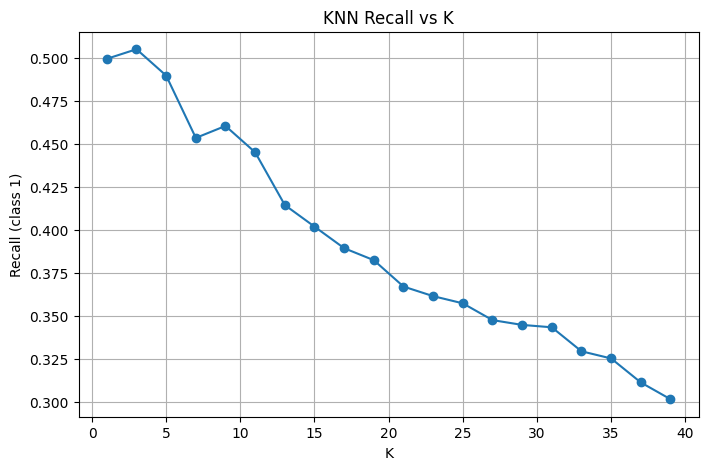

Best K (based on Recall) = 3


In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

k_values = list(range(1, 41, 2))  # odd numbers from 1 to 39
recalls = []
accuracies = []

print("Running improved KNN...")

for k in k_values:

    # Correct: only THIS pipeline must be used
    model = Pipeline([
        ("preprocess", preprocessor),
        ("knn", KNeighborsClassifier(
            n_neighbors=k,
            weights='distance',
            metric='minkowski',
            p=1
        ))
    ])
    
    # Fit on TRAIN data
    model.fit(X_train, y_train)
    
    # Predict on TEST data
    y_pred = model.predict(X_test)
    
    # Store metrics
    recalls.append(recall_score(y_test, y_pred))
    accuracies.append(accuracy_score(y_test, y_pred))

# Plot recall curve
plt.figure(figsize=(8,5))
plt.plot(k_values, recalls, marker='o')
plt.title("KNN Recall vs K")
plt.xlabel("K")
plt.ylabel("Recall (class 1)")
plt.grid(True)
plt.show()

print("Best K (based on Recall) =", k_values[recalls.index(max(recalls))])


Accuracy (K=11): 0.8537641572285143
AUC: 0.8603337116511532

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.98      0.91      2283
           1       0.89      0.45      0.59       719

    accuracy                           0.85      3002
   macro avg       0.87      0.71      0.75      3002
weighted avg       0.86      0.85      0.83      3002



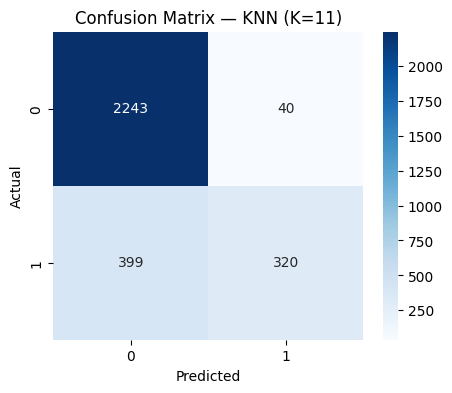

In [5]:
# ============================================
# FINAL BASELINE KNN (Using stable K = 11)
# ============================================

from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

best_stable_k = 11   # chosen after analyzing elbow but avoiding unstable K=1

knn_final = Pipeline([
    ("preprocess", preprocessor),
    ("knn", KNeighborsClassifier(
        n_neighbors=best_stable_k,
        weights="distance",
        metric="minkowski",
        p=1
    ))
])

# Train
knn_final.fit(X_train, y_train)

# Predict
y_pred_knn = knn_final.predict(X_test)
y_prob_knn = knn_final.predict_proba(X_test)[:, 1]

print(f"Accuracy (K={best_stable_k}):", accuracy_score(y_test, y_pred_knn))
print("AUC:", roc_auc_score(y_test, y_prob_knn))
print("\nClassification Report:\n", classification_report(y_test, y_pred_knn))

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix — KNN (K={best_stable_k})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Training Final KNN Model with SVD...

Final KNN With SVD — Performance:
Accuracy: 0.8204530313124584
AUC: 0.8475586316469863

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.99      0.89      2283
           1       0.88      0.29      0.44       719

    accuracy                           0.82      3002
   macro avg       0.85      0.64      0.67      3002
weighted avg       0.83      0.82      0.78      3002



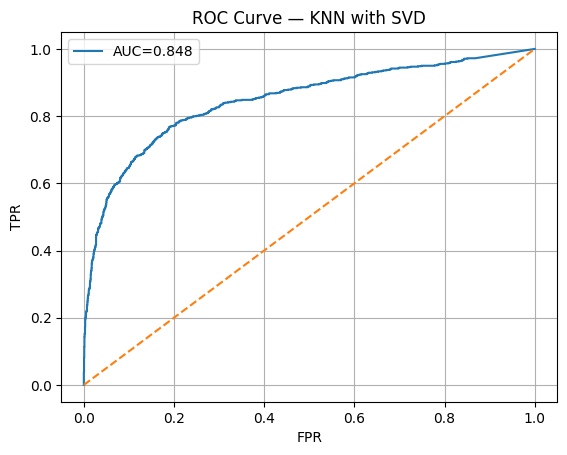

In [7]:
# ============================================
# FINAL KNN WITH TRUNCATED SVD (Recommended)
# ============================================

from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import matplotlib.pyplot as plt

print("Training Final KNN Model with SVD...")

knn_svd = Pipeline([
    ("preprocess", preprocessor),
    
    # Reduce dimensionality after OHE (very important!)
    ("svd", TruncatedSVD(
        n_components=20,      
        random_state=42
    )),
    
    ("knn", KNeighborsClassifier(
        n_neighbors=15,
        weights="distance",
        metric="minkowski",
        p=1                    # Manhattan distance
    ))
])

# Train
knn_svd.fit(X_train, y_train)

# Predict
y_pred_svd = knn_svd.predict(X_test)
y_prob_svd = knn_svd.predict_proba(X_test)[:, 1]

print("\nFinal KNN With SVD — Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_svd))
print("AUC:", roc_auc_score(y_test, y_prob_svd))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svd))

# ROC Curve (optional)
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_prob_svd)
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_test, y_prob_svd):.3f}")
plt.plot([0,1], [0,1], '--')
plt.title("ROC Curve — KNN with SVD")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid(True)
plt.show()


In [9]:
# ============================================
# SAVE FINAL KNN SVD MODEL
# ============================================

import joblib

final_knn_model = knn_svd
joblib.dump(final_knn_model, "../models/knn_svd.pkl")

print("Saved KNN SVD model as knn_svd.pkl")


Saved KNN SVD model as knn_svd.pkl
